### 1. Important Packages

In [1]:
# Mount Google Drive on Google Colab
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive/Hindi Dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import string
import re
import pickle

from __future__ import print_function
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline
hindi_font = FontProperties(fname=os.path.join(root, 'Nirmala.ttf'))

In [0]:
def clean_text(sentence, language):
    """
        Input: String, String
        Output: String
        Takes in text as string. Returns text cleaned for NMT purposes.
    """
    if language == None:
        print("Please enter which language.")
        return None
        
    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)
        
    if language == 'en':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'hi':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)

        sent_temp = ''
        for c in sentence:
            if c == ' ':
                sent_temp += c
            elif ord(u'\u0900') <= ord(c) <= ord(u'\u097F'):
                sent_temp += c
        sentence = sent_temp
      
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'ma':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    else:
        print("Language not found")
        return None

In [4]:
def read_data(filename, number_of_lines):
    data = list()
    
    with open(os.path.join(root, filename)) as f:
        for i in  range(number_of_lines):
            data.extend(clean_text(tf.compat.as_str(f.readline()).strip(), 'hi').split(' '))
    return data

words = read_data('monolingual.hi', 5000000)
print("Data size %d" % len(words))

Data size 81120156


In [5]:
vocabulary_size = int(len(set(words)) // 1.2)

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Vocabulary size", vocabulary_size)
print("Most common words (+UNK)", count[:5])
print("Sample data", data[:10])
del words

Vocabulary size 843415
Most common words (+UNK) [['UNK', 168684], ('के', 2982505), ('है', 2469644), ('में', 2233078), ('की', 1882351)]
Sample data [150, 458, 3, 13880, 1, 287, 8, 62231, 86, 794]


In [6]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('Data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print("\nwith bag_window = %d:" % (bag_window))
    print(" batch:", [[reverse_dictionary[w] for w in bi] for bi in batch])
    print(" label:", [reverse_dictionary[li] for li in labels.reshape(4)])

Data: ['भारतीय', 'राजनीति', 'में', 'पिछड़ेपन', 'के', 'विचार', 'का', 'सूत्रीकरण', 'उसे', 'खत्म', 'करने', 'के', 'मकसद', 'से', 'किया', 'गया']

with bag_window = 1:
 batch: [['भारतीय', 'में'], ['राजनीति', 'पिछड़ेपन'], ['में', 'के'], ['पिछड़ेपन', 'विचार']]
 label: ['राजनीति', 'में', 'पिछड़ेपन', 'के']

with bag_window = 2:
 batch: [['भारतीय', 'राजनीति', 'पिछड़ेपन', 'के'], ['राजनीति', 'में', 'के', 'विचार'], ['में', 'पिछड़ेपन', 'विचार', 'का'], ['पिछड़ेपन', 'के', 'का', 'सूत्रीकरण']]
 label: ['में', 'पिछड़ेपन', 'के', 'विचार']


### 3. Tensorflow Graph

In [7]:
batch_size = 128
embedding_size = 128
bag_window = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, 
                                                     inputs=tf.reduce_sum(embeds, 1), labels=train_labels, 
                                                     num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, bag_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print("Average loss at step %d: %f" % (step, average_loss))
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = "Nearest to %s:" % valid_word
                
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = "%s %s" % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 10.734385
Nearest to इन: इनट्रडर बेअदबियां शीर्षनए हिरनौटा भडांर ल्युकसआर्ट्स खर्री दोड़ाया
Nearest to ये: चोअ तेजोदीप्त दाय स्लैडम बीसवैक्स ठेक्कुनी तुकड़ोजी गुणकों
Nearest to तो: झांकियाँ मुझेये काउंटरटेरेरिज्म तूतो उन्होंनेगुप्ताजी दुकानदरी ख़ाएफ़ एकमोहल्ला
Nearest to करने: श्वसनी प्रतिअसहिष्णु खसर अनैदानिक इन्नोसेन्टी किब्बूटज लेखकिय रोसिया
Nearest to उनके: सेनथोम कुंवारे बनाद बजाईये शांगहाए तद्रिन चंद्रींचि आदिलेने
Nearest to जो: जोशौर्य निकोसिया रुकबानुर मुक्तियान घिरनेवाले िक्रस्टीना संस्कृता प्रोक्षण
Nearest to लोगों: कलमकारजी बाज़ारु बाहरेन सैनाचार्य भूसाम्राज्य बरेलीवाले गडन विंज्ञानों
Nearest to क्या: अदूदर्शिता तलु संवाई लोकतंन्त्र गोरखपुरसयंत्र चमचाई शांतीभवन परन्मतु
Nearest to कई: पंजियार प्रोत फिरवा नकुलीश मेंदफ़्न लिज राजानंदजी ईंटरल्युड्स
Nearest to किसी: संवर्गवार डिफरेन्शल औरजलप्रापातों दिव्यपक्ष बृ महफूज़ स्पेंडर्स जोरोंके
Nearest to जब: क्रांतकारी राजकुमारक

### 4. Output Visualization

In [0]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

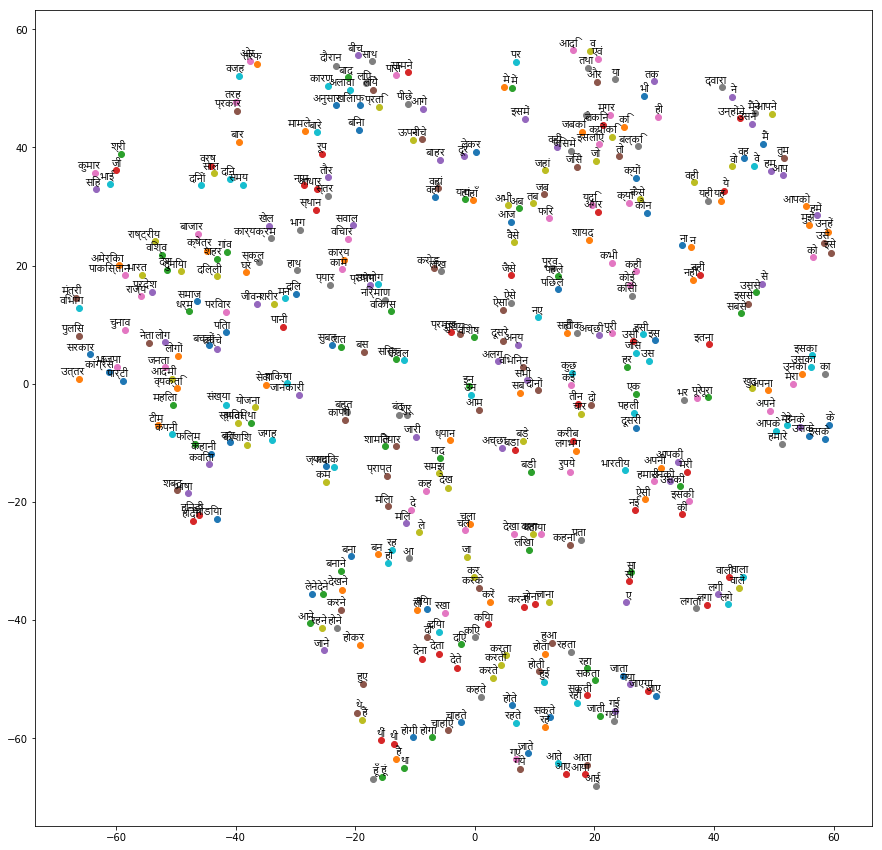

In [10]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=hindi_font)
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [0]:
final_data = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [0]:
with open(os.path.join(root, 'embeddings_cbow.hi'), 'wb') as f:
    pickle.dump(file=f, obj=final_data)